# Implementing Neural Networks with Keras
* Author: Johannes Maucher
* Last Update: 02.11.2020

## What you will learn:
* Define, train and evaluate MLP in Keras
* Define, train and evaluate CNN in Keras
* Visualization of learning-curves
* Implement cross-validation in Keras
* Image classification based on the CIFAR-10 dataset, which is included in [Keras datasets](https://keras.io/datasets/).

## Imports and Configurations

In [1]:
#!pip install Pillow
#!pip install tensorflow-cpu

In [2]:
#!pip install --upgrade numpy

In [3]:
#import tensorflow
#from tensorflow import keras

In [4]:
%matplotlib inline
#from keras.datasets import cifar10
from matplotlib import pyplot as plt
import numpy as np
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense,Input,Dropout,Flatten,Conv2D,MaxPool2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.backend import set_image_data_format
import os

In [5]:
set_image_data_format("channels_last")

In [6]:
import warnings
warnings.filterwarnings("ignore") 

The following code-cell is just relevant if notebook is executed on a computer with multiple GPUs. It allows to select the GPU. 

In [7]:
#from os import environ
#environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
#environ["CUDA_VISIBLE_DEVICES"]="1"

In this notebook the neural network shall not learn models, which already exists. This is implemented as follows. The three models (MLP and two different CNNs) are saved to the files, whose name is assigned to the variables `mlpmodelname`, `cnnsimplemodelname` and `cnnadvancedmodelname`, respectively. 
If these files exist (checked by `os.path.isfile(filename)`) a corresponding AVAILABLE-Flag is set. If this flag is `False`, the corresponding model will be learned and saved, otherwise the existing model will be loaded from disc.

In [8]:
modeldirectory="models/"
mlpmodelname=modeldirectory+"dense512"
cnnsimplemodelname=modeldirectory+"2conv32-dense512"
cnnadvancedmodelname=modeldirectory+"2conv32-4conv64-dense512"

In [9]:
import os.path

if os.path.isdir(mlpmodelname):
    MLP_AVAILABLE=True
else:
    MLP_AVAILABLE=False
    
if os.path.isdir(cnnsimplemodelname):
    CNN1_AVAILABLE=True
else:
    CNN1_AVAILABLE=False
    
if os.path.isdir(cnnadvancedmodelname):
    CNN2_AVAILABLE=True
else:
    CNN2_AVAILABLE=False

In [10]:
CNN1_AVAILABLE

True

## Access Data 

Load the Cifar10 image dataset from `keras.datasets`. Determine the shape of the training- and the test-partition.

In [11]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [12]:
print(np.shape(X_train))
print(np.shape(X_test))

(50000, 32, 32, 3)
(10000, 32, 32, 3)


## Visualize Data

Viusalize the first 9 images of the training-partition, using function `imshow()` from `matplotlib.pyplot`.

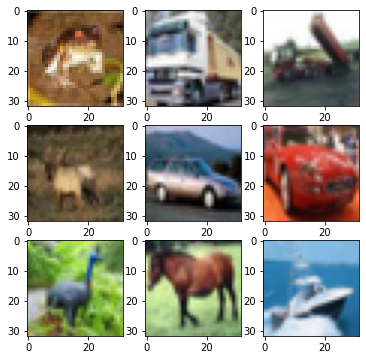

In [13]:
# create a grid of 3x3 images
plt.figure(figsize=(6,6))
for i in range(9):
    plt.subplot(3,3,i+1)
    B=X_train[i].copy()
    #B=B.swapaxes(0,2)
    #B=B.swapaxes(0,1)
    plt.imshow(B)
# show the plot
plt.show()

## Preprocessing 
Scale all images such that all their values are in the range $[0,1]$.

In [14]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = X_train / 255.0
X_test = X_test / 255.0

Labels of the first 9 training images:

In [15]:
print(y_train[:9])

[[6]
 [9]
 [9]
 [4]
 [1]
 [1]
 [2]
 [7]
 [8]]


**Label-Encoding:** Transform the labels of the train- and test-partition into a one-hot-encoded representation. 

In [16]:
y_train=to_categorical(y_train)
y_test=to_categorical(y_test)
num_classes=len(y_train[0,:])
print(y_train[:9,:])

[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]


## MLP
### Architecture
In Keras the architecture of neural networks can be defined in two different ways:

* Using the `Sequential` model
* Using the functional API

Below the two approaches are demonstrated. The first approach is simpler, but restricted to neural networks which consist of a linear stack of layers. The second approach is more flexible and allows to define quit complex network architectures, e.g. with more than one input, more than one output or with parallel branches.

#### Network definition option1: Using the sequential model

In [17]:
if MLP_AVAILABLE:
    model=load_model(mlpmodelname)
    print("MLP MODEL ALREADY AVAILABLE \nLOAD EXISTING MODEL")
else:
    model = Sequential()
    model.add(Flatten(input_shape=(32, 32,3)))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
model.summary()

2022-02-25 14:14:11.166656: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


MLP MODEL ALREADY AVAILABLE 
LOAD EXISTING MODEL
Model: "sequential"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 flatten (Flatten)           (None, 3072)              0         


 dense (Dense)               (None, 512)               1573376   


 dense_1 (Dense)             (None, 10)                5130      


Total params: 1,578,506


Trainable params: 1,578,506


Non-trainable params: 0


_________________________________________________________________


#### Network definition option 2: Using the functional API

In [18]:
# This returns a tensor
inputs = Input(shape=(32, 32,3))
x=Flatten()(inputs)
x=Dense(512, activation='relu')(x)
x=Dense(num_classes, activation='softmax')(x)
model2 = Model(inputs=inputs, outputs=x)
model2.summary()

Model: "model"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         


 flatten (Flatten)           (None, 3072)              0         


 dense (Dense)               (None, 512)               1573376   


 dense_1 (Dense)             (None, 10)                5130      


Total params: 1,578,506


Trainable params: 1,578,506


Non-trainable params: 0


_________________________________________________________________


### Define Training Parameters 
Apply Stochastic Gradient Descent (SGD) learning, for minimizing the `categorical_crossentropy`. The performance metric shall be `accuracy`. Train the network.

In [19]:
if not MLP_AVAILABLE:
    # Compile model
    epochs = 8
    lrate = 0.01
    decay = lrate/epochs
    sgd = SGD(lr=lrate, momentum=0.9, decay=decay)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

### Perform Training

In [20]:
if not MLP_AVAILABLE:
    history=model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=32,verbose=False)
    model.save(mlpmodelname)
    MLP_AVAILABLE=True
else:
    print("TRAINED MODEL ALREADY AVAILABLE")

TRAINED MODEL ALREADY AVAILABLE


### Evaluation 
Visualize the learning-curve on training- and test-data. 

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
sb.set_style("whitegrid")
sb.set_context("notebook")

In [22]:
try:
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    max_val_acc=np.max(val_acc)

    epochs = range(1, len(acc) + 1)

    plt.figure()

    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.show()
except:
    print("LEARNING CURVE ONLY AVAILABLE IF TRAINING HAS BEEN PERFORMED IN THIS RUN")

LEARNING CURVE ONLY AVAILABLE IF TRAINING HAS BEEN PERFORMED IN THIS RUN


In [23]:
loss,acc = model.evaluate(X_train,y_train, verbose=0)
print("Accuracy on Training Data : %.2f%%" % (acc*100))

Accuracy on Training Data : 50.61%


In [24]:
loss,acc = model.evaluate(X_test,y_test, verbose=0)
print("Accuracy on Test Data: %.2f%%" % (acc*100))

Accuracy on Test Data: 48.32%


## CNN 
### Define Architecture

In [25]:
if CNN1_AVAILABLE:
    model=load_model(cnnsimplemodelname)
    print("CNN SIMPLE MODEL ALREADY AVAILABLE \nLOAD EXISTING MODEL")
else:    
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(32, 32,3), padding='same',activation='relu'))
    model.add(Dropout(0.2))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu',padding='same'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
model.summary()

CNN SIMPLE MODEL ALREADY AVAILABLE 
LOAD EXISTING MODEL
Model: "sequential_2"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 conv2d_2 (Conv2D)           (None, 32, 32, 32)        896       


 conv2d_3 (Conv2D)           (None, 32, 32, 32)        9248      


 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         


 2D)                                                             


 flatten_3 (Flatten)         (None, 8192)              0         


 dense_6 (Dense)             (None, 512)               4194816   


 dense_7 (Dense)             (None, 10)                5130      


Total params: 4,210,090


Trainable params: 4,210,090


Non-trainable params: 0


_________________________________________________________________


### Define Training Parameters

In [26]:
if not CNN1_AVAILABLE:
    # Compile model
    epochs = 10
    lrate = 0.01
    decay = lrate/epochs
    sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

### Perform Training

In [27]:
if not CNN1_AVAILABLE:
    history=model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=32)
    model.save(cnnsimplemodelname)
    CNN1_AVAILABLE=True
else:
    print("TRAINED MODEL ALREADY AVAILABLE")

TRAINED MODEL ALREADY AVAILABLE


### Evaluation

In [28]:
try:
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    max_val_acc=np.max(val_acc)

    epochs = range(1, len(acc) + 1)

    plt.figure()

    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.show()
except:
    print("LEARNING CURVE ONLY AVAILABLE IF TRAINING HAS BEEN PERFORMED IN THIS RUN")

LEARNING CURVE ONLY AVAILABLE IF TRAINING HAS BEEN PERFORMED IN THIS RUN


In [29]:
loss,acc = model.evaluate(X_train,y_train, verbose=0)
print("Accuracy on Training Data : %.2f%%" % (acc*100))

Accuracy on Training Data : 99.07%


In [30]:
loss,acc = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy on Test Data: %.2f%%" % (acc*100))

Accuracy on Test Data: 68.77%


## A more complex CNN

### Architecture

In [31]:
def createModel():
    model = Sequential()
    # The first two layers with 32 filters of window size 3x3
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32, 32,3)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

In [32]:
if CNN2_AVAILABLE:
    model=load_model(cnnadvancedmodelname)
    print("CNN ADVANCED MODEL ALREADY AVAILABLE \nLOAD EXISTING MODEL")
else:  
    model = createModel()
model.summary()

CNN ADVANCED MODEL ALREADY AVAILABLE 
LOAD EXISTING MODEL
Model: "sequential_4"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 conv2d_10 (Conv2D)          (None, 32, 32, 32)        896       


 conv2d_11 (Conv2D)          (None, 30, 30, 32)        9248      


 max_pooling2d_5 (MaxPooling  (None, 15, 15, 32)       0         


 2D)                                                             


 conv2d_12 (Conv2D)          (None, 15, 15, 64)        18496     


 conv2d_13 (Conv2D)          (None, 13, 13, 64)        36928     


 max_pooling2d_6 (MaxPooling  (None, 6, 6, 64)         0         


 2D)                                                             


 conv2d_14 (Conv2D)          (None, 6, 6, 64)          36928     


 conv2d_15 (Conv2D)          (None, 4, 4, 64)          36928     


 max_pooling2d_7 (MaxPooling  (None, 2, 2, 64)         0         


 2D)                                                             


 flatten_5 (Flatten)         (None, 256)               0         


 dense_10 (Dense)            (None, 512)               131584    


 dense_11 (Dense)            (None, 10)                5130      


Total params: 276,138


Trainable params: 276,138


Non-trainable params: 0


_________________________________________________________________


### Define Training Parameters

In [33]:
if not CNN2_AVAILABLE:
    batch_size = 256
    epochs = 50
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### Perform Training

In [34]:
if not CNN2_AVAILABLE:
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=0, validation_data=(X_test, y_test))
    model.save(cnnadvancedmodelname)
    CNN2_AVAILABLE=True
else:
    print("TRAINED MODEL ALREADY AVAILABLE")

TRAINED MODEL ALREADY AVAILABLE


### Evaluate

In [35]:
try:
    plt.figure(figsize=[8,6])
    plt.plot(history.history['accuracy'],'r',linewidth=3.0)
    plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
    plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
    plt.xlabel('Epochs ',fontsize=16)
    plt.ylabel('Accuracy',fontsize=16)
    plt.title('Accuracy Curves',fontsize=16)
    plt.show()
except:
    print("LEARNING CURVE ONLY AVAILABLE IF TRAINING HAS BEEN PERFORMED IN THIS RUN")

LEARNING CURVE ONLY AVAILABLE IF TRAINING HAS BEEN PERFORMED IN THIS RUN


<Figure size 576x432 with 0 Axes>

In [36]:
loss,acc = model.evaluate(X_train,y_train, verbose=0)
print("Accuracy on Training Data : %.2f%%" % (acc*100))

Accuracy on Training Data : 98.01%


In [37]:
loss,acc = model.evaluate(X_test,y_test, verbose=0)
print("Accuracy on Test Data : %.2f%%" % (acc*100))

Accuracy on Test Data : 74.47%


## Implementation of Cross Validation in Keras

Here: Cross-Validation of MLP

In [38]:
CROSS_VAL=True

In [39]:
def build_model_mlp():
    model = Sequential()
    model.add(Flatten(input_shape=(32, 32,3)))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))
    ###################################################
    model.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])
    return model

In [40]:
def cross_validation(build_model,train_data,train_targets,folds=3,num_epochs=10):
    num_val_samples = int(len(train_data) / folds)
    all_scores = []
    for i in range(folds):
        print('processing fold #', i)
        val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
        val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

        partial_train_data = np.concatenate(                                     
            [train_data[:i * num_val_samples],
             train_data[(i + 1) * num_val_samples:]],
            axis=0)
        partial_train_targets = np.concatenate(
            [train_targets[:i * num_val_samples],
             train_targets[(i + 1) * num_val_samples:]],
            axis=0)

        model = build_model()                                                    
        model.fit(partial_train_data, partial_train_targets,                     
                  epochs=num_epochs, batch_size=32, verbose=0)
        val_score = model.evaluate(val_data, val_targets, verbose=0)      
        all_scores.append(val_score)
        print(" Loss on test data: %2.4f \n Accuracy on test data: %2.4f \n"% (val_score[0],val_score[1]))
    return all_scores

In [41]:
if CROSS_VAL:
    results=cross_validation(build_model_mlp,X_train,y_train)
    print(results)

processing fold # 0


KeyboardInterrupt: 